In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random
from PIL import Image,ImageFilter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA = {
    'train':'drive/My Drive/KAGGLE/Digit Recognizer/data/train.csv',
    'test':'drive/My Drive/KAGGLE/Digit Recognizer/data/test.csv',
    'sample_submission': 'drive/My Drive/KAGGLE/Digit Recognizer/data/sample_submission.csv'
}

In [3]:
train = pd.read_csv(DATA['train'])
test = pd.read_csv(DATA['test'])
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


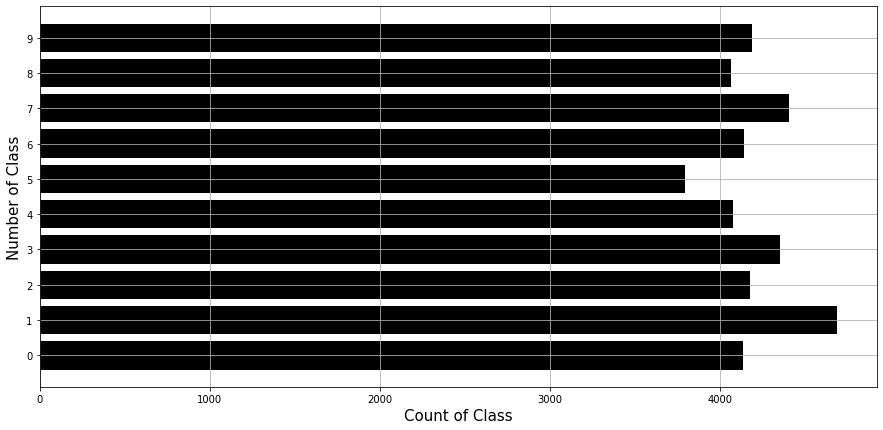

In [5]:
plt.figure(figsize = (15,7))
plt.barh(train['label'].value_counts().index,train['label'].value_counts(), color = 'k')
plt.yticks(np.arange(len(set(train['label']))))
plt.ylabel('Number of Class', fontsize = 15)
plt.xlabel('Count of Class',fontsize = 15)
plt.grid('on')

In [6]:
train_datas = train.iloc[:, train.columns != 'label'].values.astype('float32')
train_labels = train.iloc[:,0].values
test_datas = test.iloc[:,:].values.astype('float32')


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(train_datas,train_labels,
                                                    test_size = 0.2, random_state = 1)


In [8]:
X_train = X_train.reshape(X_train.shape[0], 28, 28)
X_test = X_test.reshape(X_test.shape[0], 28, 28)
test_datas = test_datas.reshape(test_datas.shape[0], 28, 28)

In [9]:
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

Y_train = torch.tensor(Y_train).type(torch.LongTensor)
Y_test = torch.tensor(Y_test).type(torch.LongTensor)

test_datas_tensor = torch.tensor(test_datas)

train_tensor = torch.utils.data.TensorDataset(X_train, Y_train)
test_tensor = torch.utils.data.TensorDataset(X_test, Y_test)

In [10]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_tensor, batch_size = BATCH_SIZE,
                              shuffle= True, num_workers = 2)
test_dataloader = DataLoader(test_tensor, batch_size = BATCH_SIZE,
                              shuffle= True, num_workers = 2)
test_loader = DataLoader(test_datas_tensor, batch_size= BATCH_SIZE, 
                         shuffle = False, num_workers = 2)

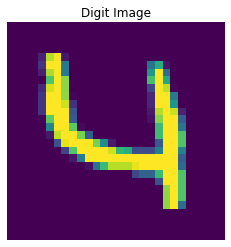

In [11]:
def plot_image(data, index):
    plt.imshow(data[index].reshape(28,28))
    plt.axis("off")
    plt.title('Digit Image')
    plt.show()

plot_image(X_train, 10)

In [12]:
num_classes = 10

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(1,32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            nn.Conv2d(32, 64,kernel_size = 3,stride = 1, padding =1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(64, 128,kernel_size = 3,stride = 1, padding =1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2)

        )

        self.fcs = nn.Sequential(
            nn.Linear(1152, 128),
            nn.Dropout(p = 0.3),
            nn.Linear(128, 64),
            nn.Dropout(p = 0.3),
            nn.Linear(64, num_classes)
        )
        
    
    def forward(self, x):
        x = self.convs(x)
        x = x.reshape(x.size(0), -1)
        x = self.fcs(x)

        output = F.log_softmax(x, dim = 1)
        return output

In [13]:
model = ConvNet().to(device)

optimizer = optim.AdamW(model.parameters(), lr = 1e-3)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} parameters')

The model has 249,610 parameters


In [15]:
def train(model, trainloader, optimizer, criterion, epoch):

    model.train()
    lr_scheduler.step()

    for batch, (images,labels) in enumerate(trainloader):
        optimizer.zero_grad()
        images = images.unsqueeze(1)

        images = images.to(device)
        labels = labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        
        if (batch + 1) % BATCH_SIZE == 0:
            print(f'Train Epoch: {epoch +1 :02} [{(batch + 1) * len(images)}/{len(trainloader.dataset)}] ({100.*(batch + 1)/len(trainloader) :.0f}%)\tLoss: {loss.item()}')

            

In [16]:
def evaluate(model, testloader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    with torch.no_grad():

        for images, labels in testloader:
            images = images.unsqueeze(1)
            images = images.to(device)
            labels = labels.to(device)

            outputs= model(images)
            loss = criterion(outputs, labels)
            acc = outputs.argmax(dim = 1,keepdim = True)

            epoch_loss+= loss
            epoch_acc += acc.eq(labels.view_as(acc)).sum().item()
    
    epoch_loss/= len(testloader.dataset)

    print(f'Average Val Loss: {epoch_loss :.4f} | Val Acc: {epoch_acc}/{len(testloader.dataset)} ({100.* epoch_acc/ len(testloader.dataset)}%)\n')

    return epoch_loss

    

In [17]:
N_EPOCHS = 30
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    train(model, train_dataloader, optimizer, criterion, epoch)
    valid_loss = evaluate(model, test_dataloader, criterion)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'digit_recognizer_model.pt')

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Epoch: 01 [1024/33600] (3%)	Loss: 0.7725074291229248
Train Epoch: 01 [2048/33600] (6%)	Loss: 0.24665194749832153
Train Epoch: 01 [3072/33600] (9%)	Loss: 0.11067753285169601
Train Epoch: 01 [4096/33600] (12%)	Loss: 0.26929932832717896
Train Epoch: 01 [5120/33600] (15%)	Loss: 0.07578345388174057
Train Epoch: 01 [6144/33600] (18%)	Loss: 0.07641436904668808
Train Epoch: 01 [7168/33600] (21%)	Loss: 0.3432362377643585
Train Epoch: 01 [8192/33600] (24%)	Loss: 0.18325914442539215
Train Epoch: 01 [9216/33600] (27%)	Loss: 0.08354638516902924
Train Epoch: 01 [10240/33600] (30%)	Loss: 0.3454186022281647
Train Epoch: 01 [11264/33600] (34%)	Loss: 0.3828682005405426
Train Epoch: 01 [12288/33600] (37%)	Loss: 0.11183151602745056
Train Epoch: 01 [13312/33600] (40%)	Loss: 0.04115361347794533
Train Epoch: 01 [14336/33600] (43%)	Loss: 0.11813078075647354
Train Epoch: 01 [15360/33600] (46%)	Loss: 0.005863693542778492
Train Epoch: 01 [16384/33600] (49%)	Loss: 0.22399811446666718
Train Epoch: 01 [17408/

In [18]:
# model.load_state_dict(torch.load('digit_recognizer_model.pt'))

In [19]:
def predict_digit(dataloader):
    model.eval()
    test_preds = torch.LongTensor()
    for i, images in enumerate(dataloader):
        images = images.unsqueeze(1)

        images = images.to(device)

        outputs = model(images)
        preds = outputs.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim = 0)
    
    return test_preds


In [20]:
test_preds = predict_digit(test_loader)
print(test_preds)

tensor([[2],
        [0],
        [9],
        ...,
        [3],
        [9],
        [2]])


In [21]:
submission = pd.read_csv(DATA['sample_submission'])
submission['Label'] = test_preds.numpy().squeeze()
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [22]:
submission.to_csv('submission.csv', index = False)

**THE RESULT OF THE SUBMISSION IS 0.992**